In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import networkx as nx

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from src.depth import DepthPoset
from src.complexes import CubicalTorusComplex
from src import depth_poset_similarity_scores

import inspect

# Cubical Torus

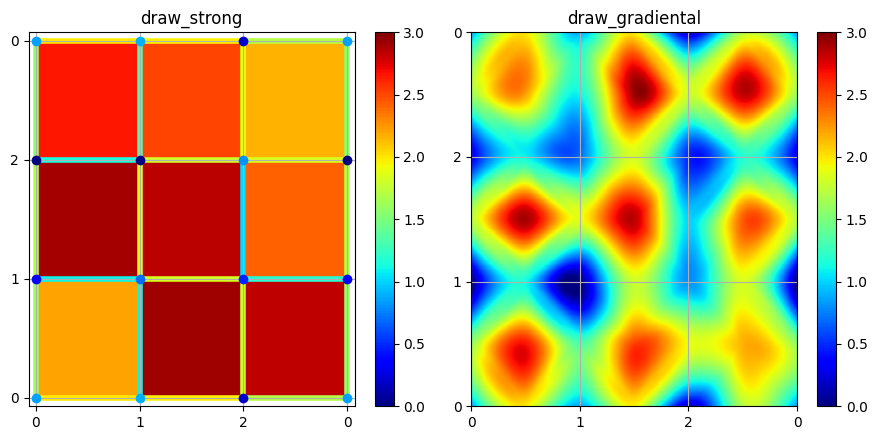

In [3]:
shape = 3, 3

ctc = CubicalTorusComplex(shape)
ctc.assign_random_barycentric_filtration()

if len(shape) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

    axs[0].set_title('draw_strong')
    sm0 = ctc.draw_strong(ax=axs[0], vmin=0, vmax=len(shape) + 1)
    axs[1].set_title('draw_gradiental')
    sm1 = ctc.draw_gradiental(ax=axs[1], vmin=0, vmax=len(shape) + 1)

    for i in range(2):
        axs[i].set_xticks(np.arange(shape[0] + 1), labels=np.arange(shape[0] + 1)%shape[0])
        axs[i].set_yticks(np.arange(shape[1] + 1), labels=np.arange(shape[1] + 1)%shape[1])
        axs[i].grid(True)

    eps = 0.07
    axs[0].set_xlim(0 - eps, shape[0] + eps)
    axs[0].set_ylim(0 - eps, shape[1] + eps)

    plt.colorbar(sm0, ax=axs[0])
    plt.colorbar(sm1, ax=axs[1])
    plt.tight_layout()
    plt.show()


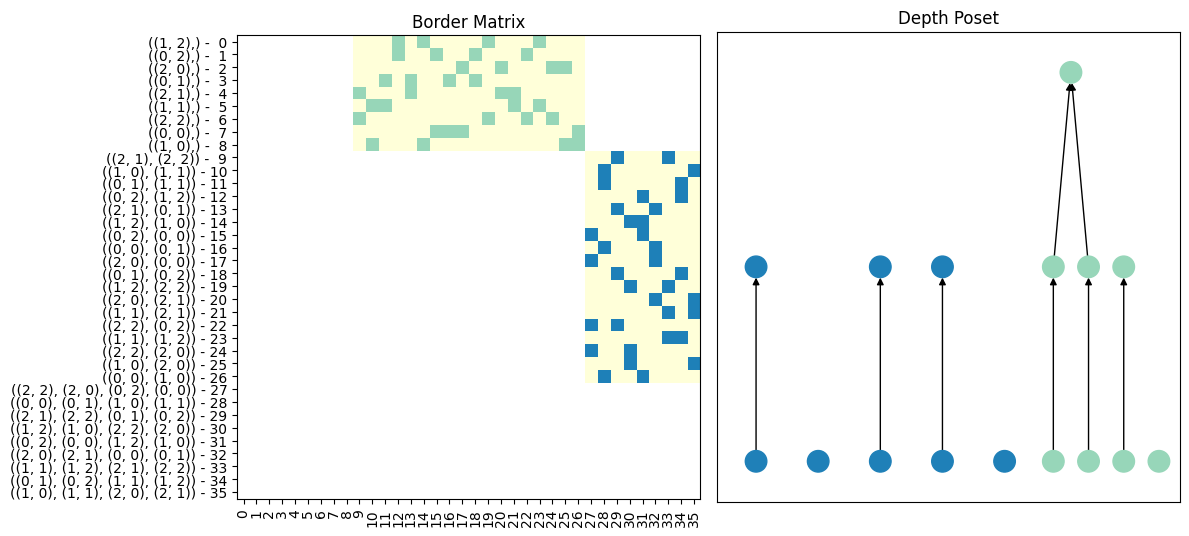

In [4]:
sort_with_filtration = True

order, dims, fvals = ctc.get_order(sort_with_filtration=sort_with_filtration, return_dims=True, return_filtration=True)
bm = ctc.get_border_matrix(sort_with_filtration=sort_with_filtration)
dp = ctc.get_depth_poset(sort_with_filtration=sort_with_filtration)

bm_show = bm.astype(float)*dims
bm_show[dims.reshape(-1, 1) - dims.reshape(1, -1) != -1] = np.nan




fig, axs = plt.subplots(1, 2, figsize=(12, 5.5))
cmap = plt.get_cmap('YlGnBu')

axs[0].set_title('Border Matrix')
axs[0].imshow(bm_show, cmap=cmap, vmax=3)
axs[0].set_yticks(np.arange(len(order)), [f'{val} -{i:>3}' for i, val in enumerate(order)], rotation=0)
axs[0].set_xticks(np.arange(len(order)), np.arange(len(order)), rotation=90)

axs[1].set_title('Depth Poset')
g = dp.get_transitive_reduction()
pos = {node: (x, -y) for node, (x, y) in nx.nx_agraph.graphviz_layout(g, prog="dot", args='-Grankdir=DU').items()}
nx.draw_networkx(g, pos=pos, node_color=[cmap((node.dim + 1)/(ctc.dim + 1)) for node in dp.nodes], node_size=240,
                 with_labels=False, ax=axs[1])

plt.tight_layout()
plt.show()

# Compare 2 complexes

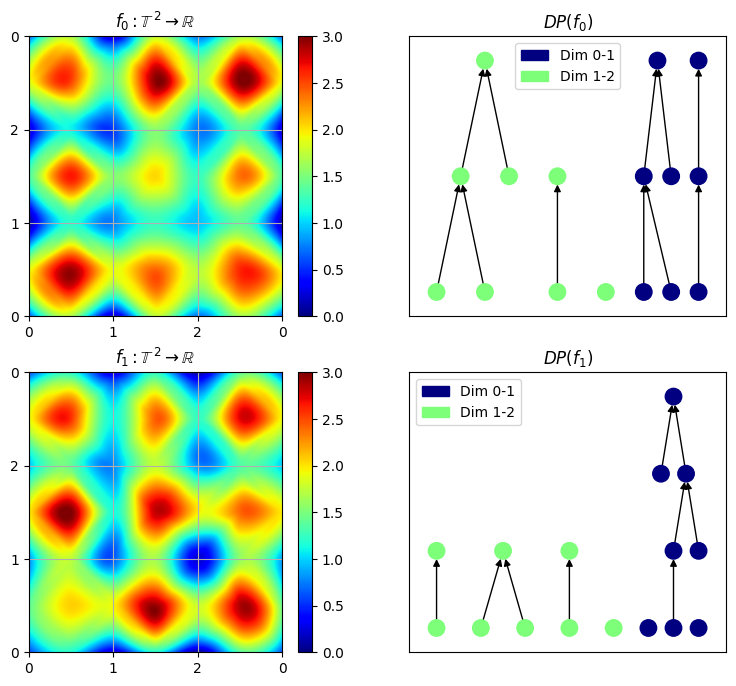

In [5]:
shape = 3, 3

ctc0 = CubicalTorusComplex(shape)
ctc0.assign_random_barycentric_filtration()
dp0 = ctc0.get_depth_poset()

ctc1 = CubicalTorusComplex(shape)
ctc1.assign_random_barycentric_filtration()
dp1 = ctc1.get_depth_poset()

fig, axs = plt.subplots(2, 2, figsize=(9, 8))

cmap_filtration = plt.get_cmap('jet')
cmap_dimensions = plt.get_cmap('jet')
for i, (ctc, dp) in enumerate([(ctc0, dp0), (ctc1, dp1)]):
    axs[i, 0].set_title(f'$f_{i}:\\mathbb{{T}}\\;^{{{len(shape)}}} \\to \\mathbb{{R}}$')
    sm = ctc.draw_gradiental(ax=axs[i, 0], cmap=cmap_filtration, vmin=0, vmax=len(shape) + 1)
    plt.colorbar(sm, ax=axs[i, 0])
    
    axs[i, 0].set_xticks(np.arange(shape[0] + 1), labels=np.arange(shape[0] + 1)%shape[0])
    axs[i, 0].set_yticks(np.arange(shape[1] + 1), labels=np.arange(shape[1] + 1)%shape[1])
    axs[i, 0].grid(True)
    
    
    axs[i, 1].set_title(f'$DP(f_{i})$')
    g = dp.get_transitive_reduction()
    pos = {node: (x, -y) for node, (x, y) in nx.nx_agraph.graphviz_layout(g, prog="dot", args='-Grankdir=DU').items()}
    nx.draw_networkx(g, pos=pos, node_color=[cmap_dimensions(node.dim/ctc.dim) for node in dp.nodes], node_size=140,
                    with_labels=False, ax=axs[i, 1])
    handles = [mpatches.Patch(color=cmap_dimensions(dim/ctc.dim), label=f"Dim {dim}-{dim + 1}") for dim in range(ctc.dim)]
    axs[i, 1].legend(handles=handles, title=None, loc="best")


In [6]:
sim_scores = [f for _, f in inspect.getmembers(depth_poset_similarity_scores, inspect.isfunction) if inspect.getmodule(f) == depth_poset_similarity_scores]

df_sim = pd.Series({(score.__name__.replace('cell', '').replace('index', '').replace('__', '_'), score.__name__.find('cell') != -1): score(dp0, dp1) for score in sim_scores})
df_sim = df_sim.unstack(level=1).rename(columns={False: 'by indices', True: 'by cells'})
df_sim

,by indices,by cells
birth_relation_similarity,1.0,1.000000
death_relation_similarity,1.0,1.000000
poset_arc_similarity,0.0,0.000000
poset_node_similarity,0.0,0.032258
relation_similarity,1.0,1.000000
